In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Signac)
library(Seurat)
library(SeuratWrappers)
library(reshape2)
library(ggplot2)
library(ggpubr)
library(pheatmap)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggpubr)
library(karyoploteR)
library(stringr)
library(dplyr)
library(patchwork)
library(cicero)
})
set.seed(123)

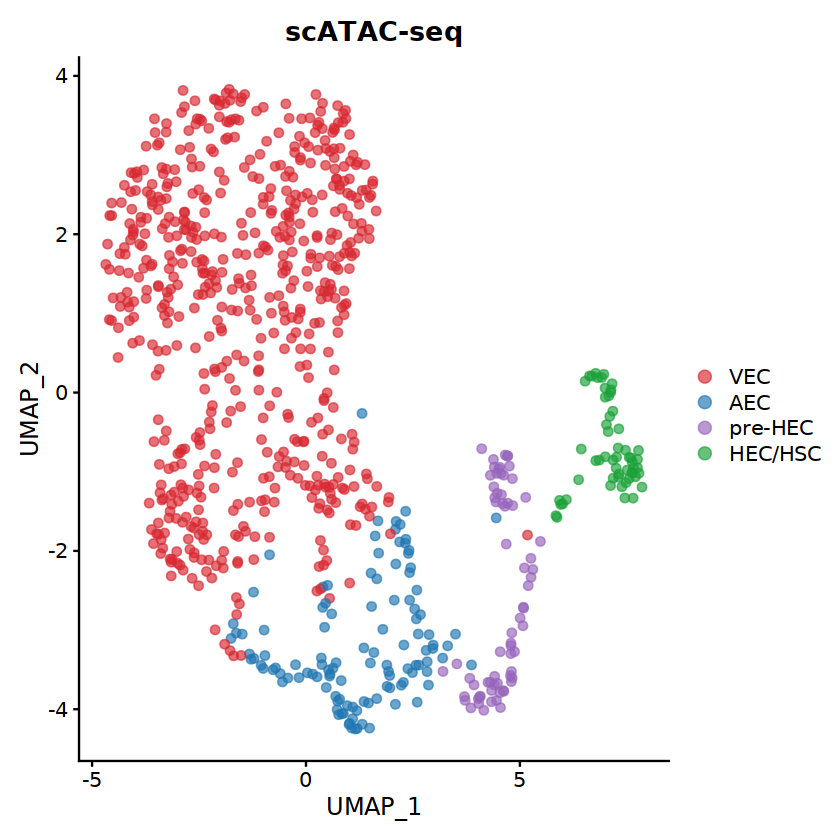

In [2]:
# load the signac object
sample <- readRDS("./sample_mouse_ATAC_annotated.rds")
DefaultAssay(sample) <- "peaks"
DimPlot(sample, group.by = 'celltype', repel = TRUE, cols = alpha(c("#D82831", "#2077B2", "#9765BA", "#1BA138"), 0.66), pt.size = 2) + ggtitle('scATAC-seq')

In [3]:
# load TE GRanges
mm10_te_granges <- readRDS("./meta/mm10_te_granges.rds")

In [4]:
# find all peaks overlapping with TEs
gr1 <- granges(sample)
gr2 <- mm10_te_granges
suppressWarnings({m <- findOverlaps(gr1, gr2, ignore.strand = TRUE)})
length(unique(queryHits(m))) / nrow(sample[["peaks"]])
gr1.matched <- gr1[queryHits(m)]
mcols(gr1.matched) <- cbind.data.frame(mcols(gr1.matched), mcols(gr2[subjectHits(m)]))

[1] 0.5897293

In [5]:
# find all differentially accessible peaks
DefaultAssay(sample) <- 'peaks'
Idents(sample) <- sample$celltype
suppressWarnings({
da_peaks_all <- FindAllMarkers(
  object = sample,
  min.pct = 0.05,
  only.pos = T,
  test.use = 'LR',
  latent.vars = 'nCount_peaks')
})

write.csv(da_peaks_all, "meta/da_peaks_all_mouse.csv")

Calculating cluster VEC

Calculating cluster AEC

Calculating cluster pre-HEC

Calculating cluster HEC/HSC



In [6]:
# create GRanges for da peaks
da_peaks_all <- read.csv("meta/da_peaks_all_mouse.csv", row.names = 1)
da_peaks_all_significant <- subset(da_peaks_all, avg_log2FC >= 0.5 & p_val_adj <= 0.05)
da_peaks_all_significant_loc <- da_peaks_all_significant$gene
da_peaks_all_significant_chr <- unlist(strsplit(da_peaks_all_significant_loc, split = "-"))[seq(1, 3 * length(da_peaks_all_significant_loc), by = 3)]
da_peaks_all_significant_start <- unlist(strsplit(da_peaks_all_significant_loc, split = "-"))[seq(2, 3 * length(da_peaks_all_significant_loc), by = 3)]
da_peaks_all_significant_end <- unlist(strsplit(da_peaks_all_significant_loc, split = "-"))[seq(3, 3 * length(da_peaks_all_significant_loc), by = 3)]
da_peaks_all_significant_df <- data.frame(chr = da_peaks_all_significant_chr, start = da_peaks_all_significant_start, end = da_peaks_all_significant_end, p_val = da_peaks_all_significant$p_val, avg_log2FC = da_peaks_all_significant$avg_log2FC, pct1 = da_peaks_all_significant$`pct.1`, pct2 = da_peaks_all_significant$`pct.2`, p_val_adj = da_peaks_all_significant$p_val_adj, celltype = da_peaks_all_significant$cluster, peak_loc = da_peaks_all_significant$gene)
da_peaks_all_significant_granges <- toGRanges(da_peaks_all_significant_df)
da_peaks_all_significant_granges

GRanges object with 2997 ranges and 7 metadata columns:
       seqnames              ranges strand |       p_val avg_log2FC      pct1
          <Rle>           <IRanges>  <Rle> |   <numeric>  <numeric> <numeric>
     1    chr18   80633191-80634076      * | 4.86987e-24    3.58591     0.328
     2     chr2 159053206-159054120      * | 8.18141e-24    2.20823     0.474
     3     chr1   91960967-91961818      * | 1.11062e-23    3.57376     0.328
     4     chr8   72131025-72131901      * | 2.01109e-22    2.12914     0.467
     5     chr7   98537607-98538498      * | 2.20265e-22    3.27318     0.330
   ...      ...                 ...    ... .         ...        ...       ...
  2993     chr9   65528136-65529054      * | 3.30047e-07    4.05950     0.161
  2994    chr10 130336329-130337131      * | 3.30537e-07    3.67051     0.161
  2995     chr9   63308882-63309617      * | 3.35691e-07    4.61172     0.143
  2996    chr19   58296510-58297383      * | 3.39606e-07    4.35156     0.125
  2997  

In [7]:
# find da peaks overlapping with TEs
gr1 <- da_peaks_all_significant_granges
gr2 <- mm10_te_granges
suppressWarnings({m <- findOverlaps(gr1, gr2, ignore.strand = TRUE)})
length(unique(queryHits(m))) / length(unique(da_peaks_all_significant$gene))
gr1.matched <- gr1[queryHits(m)]
mcols(gr1.matched) <- cbind.data.frame(mcols(gr1.matched), mcols(gr2[subjectHits(m)]))
gr1.matched

[1] 0.5741056

GRanges object with 2918 ranges and 12 metadata columns:
       seqnames              ranges strand |       p_val avg_log2FC      pct1
          <Rle>           <IRanges>  <Rle> |   <numeric>  <numeric> <numeric>
     2     chr2 159053206-159054120      * | 8.18141e-24    2.20823     0.474
     3     chr1   91960967-91961818      * | 1.11062e-23    3.57376     0.328
     4     chr8   72131025-72131901      * | 2.01109e-22    2.12914     0.467
     4     chr8   72131025-72131901      * | 2.01109e-22    2.12914     0.467
     7    chr14   73429390-73430306      * | 1.99276e-21    2.57052     0.382
   ...      ...                 ...    ... .         ...        ...       ...
  2993     chr9   65528136-65529054      * | 3.30047e-07    4.05950     0.161
  2993     chr9   65528136-65529054      * | 3.30047e-07    4.05950     0.161
  2994    chr10 130336329-130337131      * | 3.30537e-07    3.67051     0.161
  2994    chr10 130336329-130337131      * | 3.30537e-07    3.67051     0.161
  2997 

In [8]:
# group peaks to TE/non-TE overlapping
da_peaks_all_significant_granges$category <- "Other"
da_peaks_all_significant_granges[da_peaks_all_significant_granges$peak_loc %in% unique(gr1.matched$peak_loc), ]$category <- "TE"
gr1.unmatched <- da_peaks_all_significant_granges[da_peaks_all_significant_granges$category == "Other", ]
gr1.unmatched$tx_id <- "NA"
gr1.unmatched$gene_name <- "NA"
gr1.unmatched$gene_id <- "NA"
gr1.unmatched$gene_biotype <- "NA"
gr1.unmatched$type <- "NA"
gr1.unmatched$category <- NULL
da_peaks_all_siginificant_overlapping <- rbind.data.frame(as.data.frame(gr1.matched, row.names = make.names(gr1.matched$tx_id, unique = T)), as.data.frame(gr1.unmatched, row.names = make.names(gr1.unmatched$peak_loc, unique = T)))
write.csv(da_peaks_all_siginificant_overlapping, "meta/da_peaks_all_siginificant_overlapping_TE.csv", row.names = F)

In [9]:
# get closest genes of da peaks
closest_da_peaks_all_significant <- ClosestFeature(sample, da_peaks_all_significant_granges$peak_loc)
closest_da_peaks_all_significant_df <- merge(da_peaks_all_siginificant_overlapping, closest_da_peaks_all_significant, by.x = "peak_loc", by.y = "query_region", all.x = T)
celltype_markers <- read.csv("../1_EHT_RNA_Preprocessing/meta/celltype_markers_MAST_mouse.csv", row.names = 1)
closest_da_peaks_all_significant_df_merged <- merge(closest_da_peaks_all_significant_df, celltype_markers, by.x = "gene_name.y", by.y = "gene", all.x = T)
write.csv(closest_da_peaks_all_significant_df_merged, "meta/closest_da_peaks_all_significant_df_merged.csv")

Warning message in ClosestFeature(sample, da_peaks_all_significant_granges$peak_loc):
"The following seqlevels present in query regions are not present
 in the supplied gene annotations and will be removed: GL456216.1, JH584304.1"


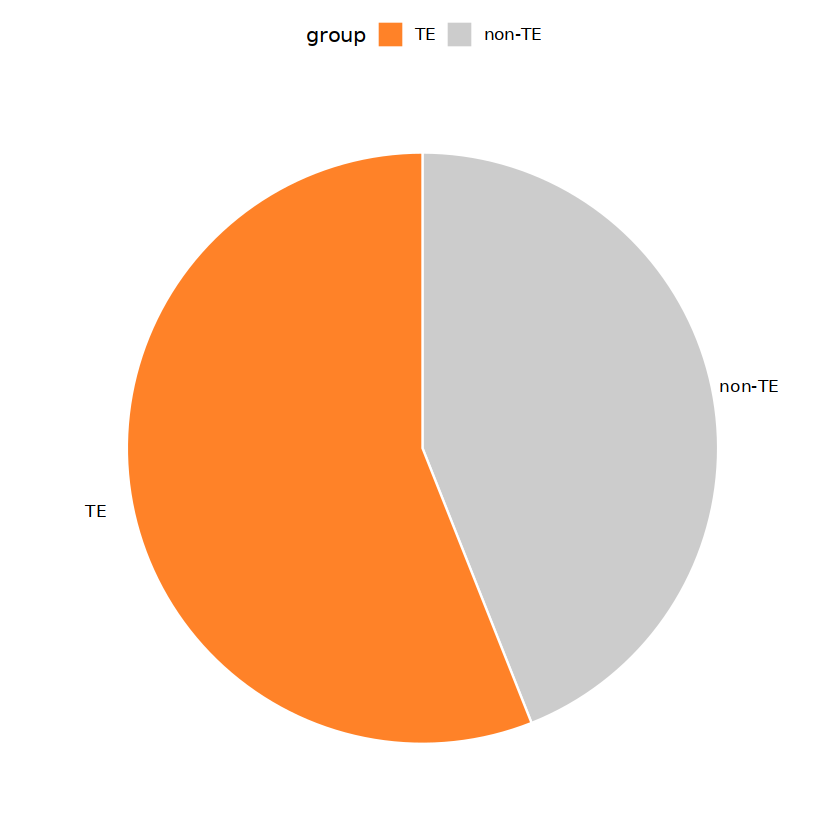

In [10]:
# plot da TE composition
celltype_all <- c("VEC","AEC","pre-HEC","HEC/HSC")
color_all <- alpha(c("#D82831", "#2077B2", "#9765BA", "#1BA138"), 0.66)
for(i in 1:4){
    cluster <- celltype_all[i]
    color <- color_all[i]
    peak_count <- nrow(da_peaks_all_siginificant_overlapping[da_peaks_all_siginificant_overlapping$celltype == cluster, ])
    te_count <- sum(da_peaks_all_siginificant_overlapping[da_peaks_all_siginificant_overlapping$celltype == cluster, "gene_name"] != "NA")
    da_te_composition <- data.frame(group = c("TE","non-TE"), value = c(te_count, peak_count - te_count))
    ggpie(da_te_composition, "value", label = "group", color = "white", fill = "group", palette = c(color, "grey80"))
    ggsave(paste("figure/da_te_composition_", gsub(pattern = "/", replacement = "_", cluster), ".pdf", sep = ""), width = 3, height = 3)
}

peak_count <- nrow(da_peaks_all_siginificant_overlapping[!duplicated(da_peaks_all_siginificant_overlapping$peak_loc), ])
te_count <- sum(da_peaks_all_siginificant_overlapping[!duplicated(da_peaks_all_siginificant_overlapping$peak_loc), "gene_name"] != "NA")
da_te_composition <- data.frame(group = c("TE","non-TE"), value = c(te_count, peak_count - te_count))
ggpie(da_te_composition, "value", label = "group", color = "white", fill = "group", palette = c("#FF8228", "grey80"))
ggsave(paste("figure/da_te_composition_all.pdf"), width = 3, height = 3)

In [11]:
# save the da peaks position to pdf
EHT_scorecard <- unique(c("CDH5","RUNX1","PTPRC","SPN","CD44","ITGA2B","HLF","GFI1","GFI1B","MLLT3","HOXA9",
                 "NRP2","NR2F2","FLI1","APLNR",
                 "GJA4","HEY1","DLL4","CXCR4","SOX17","SMAD6","GJA5","MECOM",
                 "NID2","PRND","ESM1","PDGFB","NOTCH1",
                 "PALMD","TMEM100","EDN1","LTBP4","HEY2","ACE",
                 "SULF1","CYP26B1",
                 "ADGRG6","COL23A1","GATA6","BMX","DKK1",
                 "FBN2","ELN","NKX2-3","PROCR","GATA3","GBP4",
                 "MYCN",
                 "MYB","STAT5A","SMIM24","RAB27B","SPINK2","SPI1","CORO1A","KIT"))
EHT_scorecard <- str_to_title(tolower(EHT_scorecard))
gene_annotations <- readRDS("meta/EnsDb.Mmusculus.v98.annotations.ucsc.rds")
EHT_gene_ranges <- gene_annotations[gene_annotations$gene_name %in% EHT_scorecard, ]
EHT_gene_pos_plot <- data.frame(chr = as.character(seqnames(EHT_gene_ranges)), start = as.data.frame(ranges(EHT_gene_ranges))$start, end = as.data.frame(ranges(EHT_gene_ranges))$end, label = EHT_gene_ranges$gene_name)
EHT_gene_pos_plot <- EHT_gene_pos_plot[!duplicated(EHT_gene_pos_plot$label), ]

pdf("figure/da_peaks_all_significant_position.pdf", width = 5, height = 7)
kp <- plotKaryotype(genome = "mm10", chromosomes = paste("chr", c(1:19, "X"), sep = ""), plot.type = 2)
kpAddBaseNumbers(kp)
#kpPlotRegions(kp, da_peaks_all_significant_granges[da_peaks_all_significant_granges], r0=0, r1=0.5, col=colByCategory(da_peaks_all_significant_granges$celltype, colors = c("#D82831", "#2077B2", "#9765BA", "#1BA138")), avoid.overlapping = F)

kpPlotRegions(kp, da_peaks_all_significant_granges[da_peaks_all_significant_granges$celltype == "VEC", ], r0=0, r1=0.12, col=colByCategory(da_peaks_all_significant_granges$category, colors = alpha(c("#D82831", "grey70"), 0.8)), avoid.overlapping = F)
kpPlotRegions(kp, da_peaks_all_significant_granges[da_peaks_all_significant_granges$celltype == "AEC", ], r0=0.24, r1=0.36, col=colByCategory(da_peaks_all_significant_granges$category, colors = alpha(c("#2077B2", "grey70"), 0.8)), avoid.overlapping = F)
kpPlotRegions(kp, da_peaks_all_significant_granges[da_peaks_all_significant_granges$celltype == "pre-HEC", ], r0=0.48, r1=0.60, col=colByCategory(da_peaks_all_significant_granges$category, colors = alpha(c("#9765BA", "grey70"), 0.8)), avoid.overlapping = F)
kpPlotRegions(kp, da_peaks_all_significant_granges[da_peaks_all_significant_granges$celltype == "HEC/HSC", ], r0=0.72, r1=0.84, col=colByCategory(da_peaks_all_significant_granges$category, colors = alpha(c("#1BA138", "grey70"), 0.8)), avoid.overlapping = F)

kpPlotMarkers(kp, chr=EHT_gene_pos_plot$chr, x=EHT_gene_pos_plot$start, labels=EHT_gene_pos_plot$label, text.orientation = "horizontal", data.panel = 2, cex = 0.5)
#kpPlotRegions(kp, da_peaks_all_significant_granges[da_peaks_all_significant_granges$celltype == "AEC", ], r0=0.5, r1=1, col="#2077B2", avoid.overlapping = F)
dev.off()

png 
  2

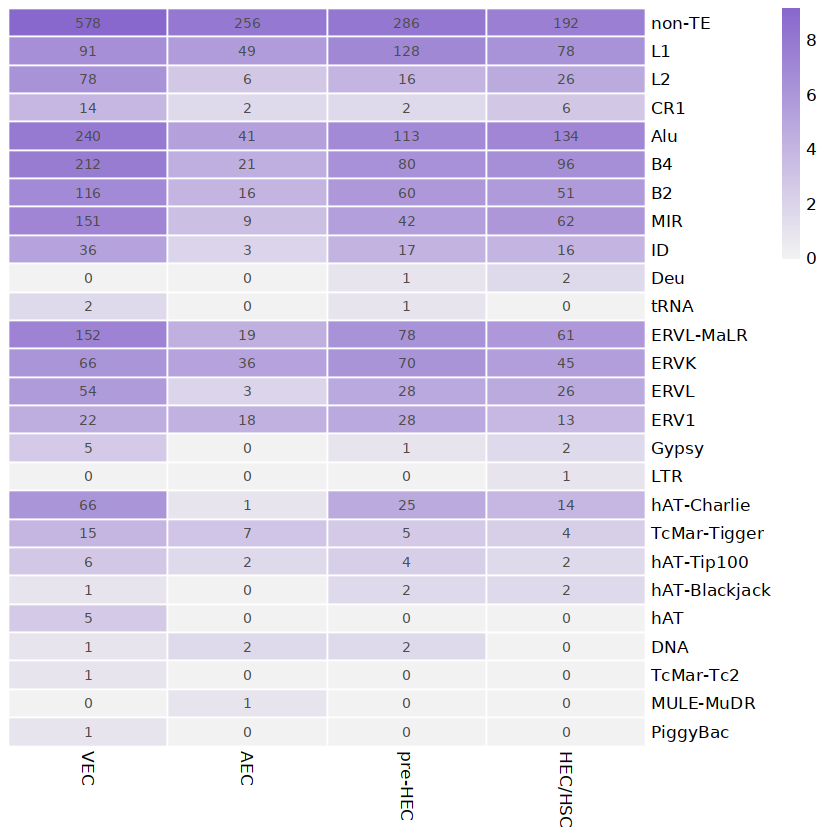

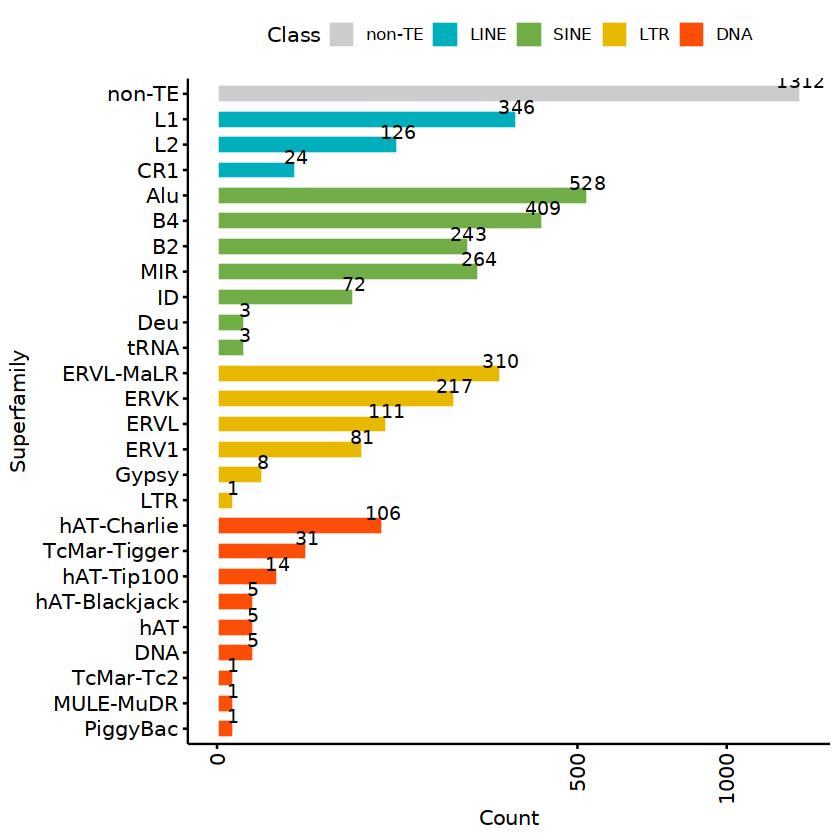

In [12]:
# count TE superfamily overlapped with da peaks
da_peaks_all_siginificant_overlapping <- read.csv("meta/da_peaks_all_siginificant_overlapping_TE.csv")
da_peaks_all_siginificant_overlapping[is.na(da_peaks_all_siginificant_overlapping$tx_id), "gene_name"] <- "non-TE.non-TE.non-TE"

te_superfamily_class_mm10 <- read.csv("meta/superfamily_count_class_mm10.csv", row.names = 1, check.names = F)
te_superfamily_class_mm10 <- te_superfamily_class_mm10[, c(1, 3)]
colnames(te_superfamily_class_mm10) <- c("Superfamily", "Class")

te_vec <- subset(da_peaks_all_siginificant_overlapping, celltype == "VEC")$gene_name
te_vec_superfamily <- unlist(strsplit(te_vec, split = ".", fixed = T))[seq(2, 3 * length(te_vec), by = 3)]
te_vec_superfamily_count <- as.data.frame(table(te_vec_superfamily))
colnames(te_vec_superfamily_count) <- c("Superfamily", "VEC")

te_aec <- subset(da_peaks_all_siginificant_overlapping, celltype == "AEC")$gene_name
te_aec_superfamily <- unlist(strsplit(te_aec, split = ".", fixed = T))[seq(2, 3 * length(te_aec), by = 3)]
te_aec_superfamily_count <- as.data.frame(table(te_aec_superfamily))
colnames(te_aec_superfamily_count) <- c("Superfamily", "AEC")

te_prehec <- subset(da_peaks_all_siginificant_overlapping, celltype == "pre-HEC")$gene_name
te_prehec_superfamily <- unlist(strsplit(te_prehec, split = ".", fixed = T))[seq(2, 3 * length(te_prehec), by = 3)]
te_prehec_superfamily_count <- as.data.frame(table(te_prehec_superfamily))
colnames(te_prehec_superfamily_count) <- c("Superfamily", "pre-HEC")

te_hsc <- subset(da_peaks_all_siginificant_overlapping, celltype == "HEC/HSC")$gene_name
te_hsc_superfamily <- unlist(strsplit(te_hsc, split = ".", fixed = T))[seq(2, 3 * length(te_hsc), by = 3)]
te_hsc_superfamily_count <- as.data.frame(table(te_hsc_superfamily))
colnames(te_hsc_superfamily_count) <- c("Superfamily", "HEC/HSC")

te_superfamily_da_all <- te_superfamily_class_mm10 %>% left_join(te_vec_superfamily_count, by = "Superfamily") %>% left_join(te_aec_superfamily_count, by = "Superfamily") %>% left_join(te_prehec_superfamily_count, by = "Superfamily") %>% left_join(te_hsc_superfamily_count, by = "Superfamily")
te_superfamily_da_all[is.na(te_superfamily_da_all)] <- 0
te_superfamily_da <- te_superfamily_da_all[rowSums(te_superfamily_da_all[, 3:6]) != 0, ]

# pheatmap
te_superfamily_da_heatmap <- te_superfamily_da[, 3:6]
rownames(te_superfamily_da_heatmap) <- te_superfamily_da$Superfamily
pheatmap(log2(te_superfamily_da_heatmap + 1), display_numbers = te_superfamily_da_heatmap, cluster_rows = F, cluster_cols = F, color = colorRampPalette(c("grey95","mediumpurple3"))(100), border_color = "white")

# barplot
te_superfamily_da_barplot <- data.frame(Superfamily = te_superfamily_da$Superfamily, Count = rowSums(te_superfamily_da[, 3:6]), Class = te_superfamily_da$Class)

te_superfamily_da_barplot$Superfamily <- factor(te_superfamily_da_barplot$Superfamily, levels = rev(te_superfamily_da_barplot$Superfamily))
te_superfamily_da_barplot$Class <- factor(te_superfamily_da_barplot$Class, levels = c("non-TE","LINE","SINE","LTR","DNA"))
class_color <- c("grey80", "#00AFBB", "#70AD47", "#E7B800", "#FC4E07")

ggbarplot(te_superfamily_da_barplot, x = "Superfamily", y = "Count",
          fill = "Class",               # change fill color by cyl
          color = "white",            # Set bar border colors to white
          palette = class_color,            # jco journal color palett. see ?ggpar
          sort.val = "none",           # Sort the value in dscending order
          x.text.angle = 90,         # Rotate vertically x axis texts
          label = TRUE, label.pos = "out"
          ) + scale_y_continuous(trans = "sqrt") + coord_flip()
ggsave("./figure/te_superfamily_mm10_da_barplot.pdf", width = 3, height = 12)

In [13]:
# convert to CellDataSet format and make the cicero object
sample_cds <- as.cell_data_set(x = sample)
sample_cicero <- make_cicero_cds(sample_cds, reduced_coordinates = reducedDims(sample_cds)$UMAP)

Warning message:
"Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object"
Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 3.44200711569133
Median shared cells bin-bin: 0



In [14]:
# get the chromosome sizes from the Seurat object
genome <- seqlengths(sample)

# convert chromosome sizes to a dataframe
genome.df <- data.frame("chr" = names(genome), "length" = genome)

# run cicero
conns <- run_cicero(sample_cicero, genomic_coords = genome.df, sample_num = 100)

[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Successful cicero models:  9485"
[1] "Other models: "

Zero or one element in range 
                        1913 
[1] "Models with errors:  0"
[1] "Done"


In [15]:
# save the raw connections
# saveRDS(conns, "conns_mouse_raw.rds")
conns <- readRDS("conns_mouse_raw.rds")

In [16]:
# find links between TE related da peaks
da_peaks_all_siginificant_overlapping <- read.csv("meta/da_peaks_all_siginificant_overlapping_TE.csv")
#da_peaks_TEs_all <- na.omit(da_peaks_all_siginificant_overlapping)
da_peaks_TEs_all <- da_peaks_all_siginificant_overlapping

conns_te <- na.omit(conns)
conns_te$Peak2 <- as.character(conns_te$Peak2)
conns_p1_te <- conns_te[conns_te$Peak1 %in% unique(da_peaks_TEs_all$peak_loc), ]
conns_p2_te <- conns_p1_te[conns_p1_te$Peak2 %in% unique(da_peaks_TEs_all$peak_loc), ]
conns_te_all <- conns_p2_te

conns_te_all <- conns_te_all[order(conns_te_all$coaccess), ]
write.csv(conns_te_all[seq(1, nrow(conns_te_all), by = 2), ], "meta/conns_da_raw.csv")

In [17]:
# filter the conns
conns_filtered_na <- na.omit(conns)
conns_filtered <- conns_filtered_na[conns_filtered_na$coaccess >= 0.4, ]
#write.csv(conns_filtered, "conns_filtered_04_mouse.csv")

In [18]:
# generate CCANs (optimum coaccessibility cutoff = 0.4)
ccans <- generate_ccans(conns_filtered_na, coaccess_cutoff_override = 0.4)

[1] "Coaccessibility cutoff used: 0.4"


In [19]:
# add links to a Seurat object
DefaultAssay(sample) <- "peaks"
links <- ConnectionsToLinks(conns = conns_filtered_na, ccans = ccans)
Links(sample) <- links

In [20]:
# save the linked object
saveRDS(sample, file = "sample_mouse_ATAC_cicero.rds")

In [21]:
# make annotations with TEs
mm10_te_granges <- readRDS("./meta/mm10_te_granges.rds")
gr1 <- mm10_te_granges
gr2 <- granges(sample)
suppressWarnings({m <- findOverlaps(gr1, gr2, ignore.strand = TRUE)})
gr1.matched <- gr1[queryHits(m)]
mcols(gr1.matched) <- cbind.data.frame(mcols(gr1.matched))
mm10_te_granges_matched <- gr1.matched

In [23]:
# make annotations with genes
gene_annotations <- readRDS("meta/EnsDb.Mmusculus.v98.annotations.ucsc.rds")
mm10_te_gene_annotations <- makeGRangesFromDataFrame(rbind(as.data.frame(mm10_te_granges_matched), as.data.frame(gene_annotations, row.names = make.names(gene_annotations$tx_id, unique = T))), keep.extra.columns = T)
sample_te_gene <- sample
DefaultAssay(sample_te_gene) <- "peaks"
Annotation(sample_te_gene) <- mm10_te_gene_annotations

In [24]:
# annotate peaks
gr1 <- granges(sample)
gr2 <- da_peaks_all_significant_granges
suppressWarnings({m <- findOverlaps(gr1, gr2, ignore.strand = TRUE)})
gr1.matched <- gr1[queryHits(m)]
mcols(gr1.matched) <- cbind.data.frame(mcols(gr1.matched), mcols(gr2[subjectHits(m)]))

gr1$celltype <- "Other"
gr1[queryHits(m)]$celltype <- gr1.matched$celltype

sample_peak <- sample
DefaultAssay(sample_peak) <- "peaks"
sample_peak@assays$peaks@meta.features$celltype <- factor(gr1$celltype, levels = c("VEC","AEC","pre-HEC","HEC/HSC", "Other"))

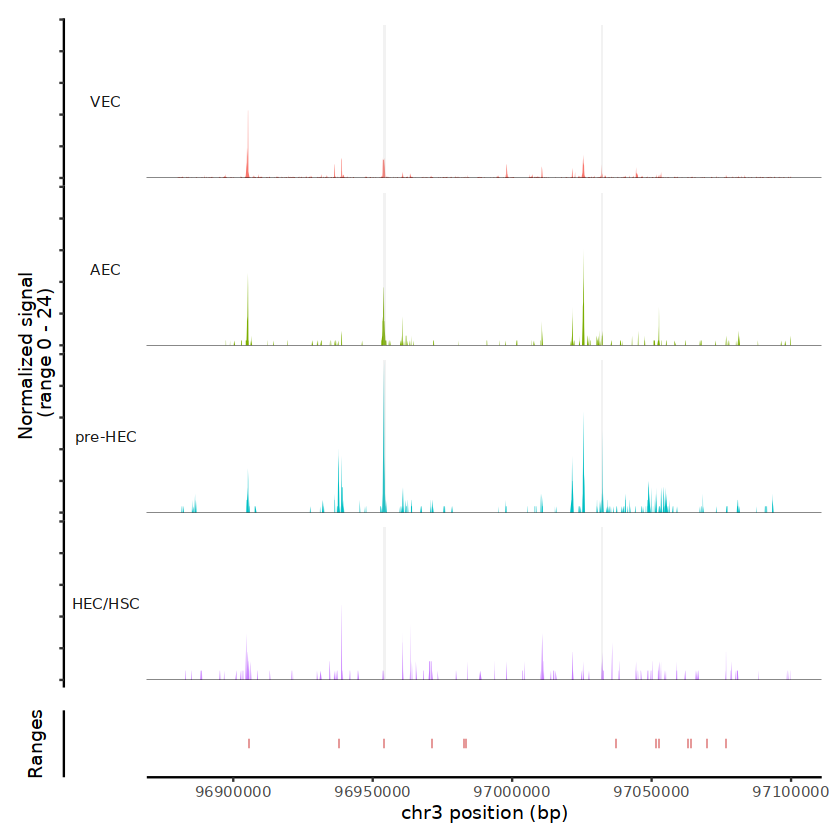

In [25]:
# plot coverage Gja5
els_gja5 <- StringToGRanges(c("chr3-96904963-96905178","chr3-96905569-96905733",'chr3-96937706-96937945','chr3-96953858-96954172','chr3-96971124-96971466','chr3-96982467-96982617','chr3-96982689-96983026','chr3-96983275-96983478','chr3-97037102-97037392','chr3-97039767-97040091','chr3-97051339-97051674','chr3-97052406-97052751','chr3-97062851-97063201','chr3-97064098-97064357','chr3-97069667-97069992','chr3-97072485-97072673','chr3-97076460-97076788','chr3-97058750-97059076'))
ranges.highlight <- StringToGRanges(c("chr3-96954000-96954600","chr3-97032100-97032500"))
cov_plot <- CoveragePlot(
  object = sample,
  region = "chr3-96880000-97100000",
  region.highlight = ranges.highlight,
  ranges = els_gja5,
  annotation = FALSE,
  peaks = FALSE,
  links = FALSE
) + scale_fill_manual(values = alpha(c("#D82831", "#2077B2", "#9765BA", "#1BA138"), 0.33))
cov_plot
#ggsave("./figure/cov_plot_Gja5.pdf", width = 8, height = 3)

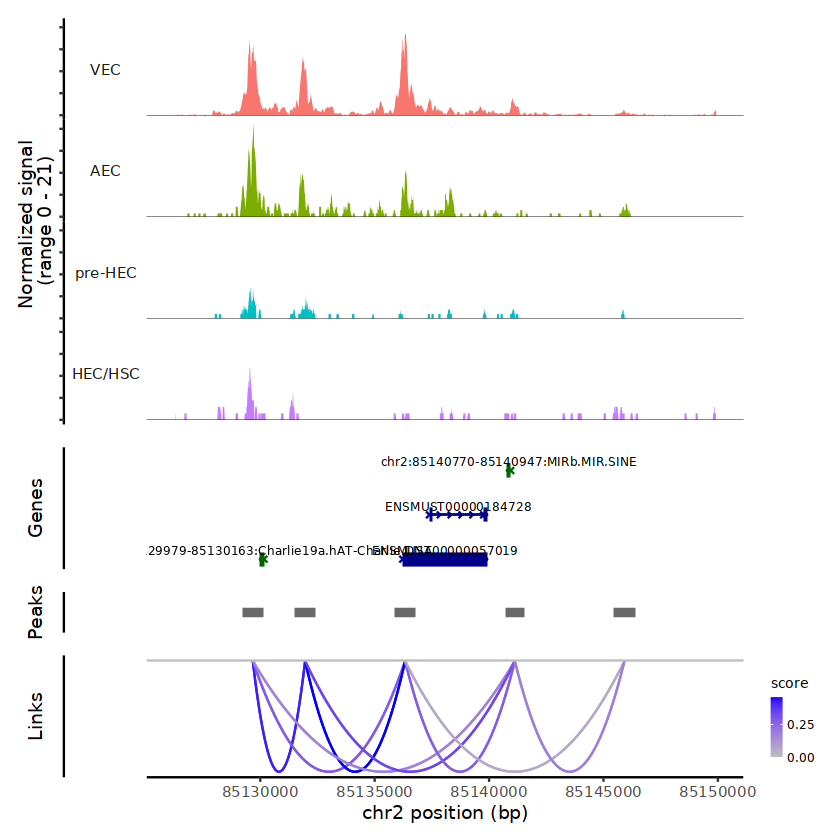

In [26]:
# plot coverage Aplnr
CoveragePlot(
  object = sample_te_gene,
  region = "Aplnr",
  extend.upstream = 10000,
  extend.downstream = 10000,
  annotation = "transcript"
) + scale_fill_manual(values = alpha(c("#D82831", "#2077B2", "#9765BA", "#1BA138"), 0.33))

Warning message:
"Removed 8 rows containing missing values (`geom_segment()`)."


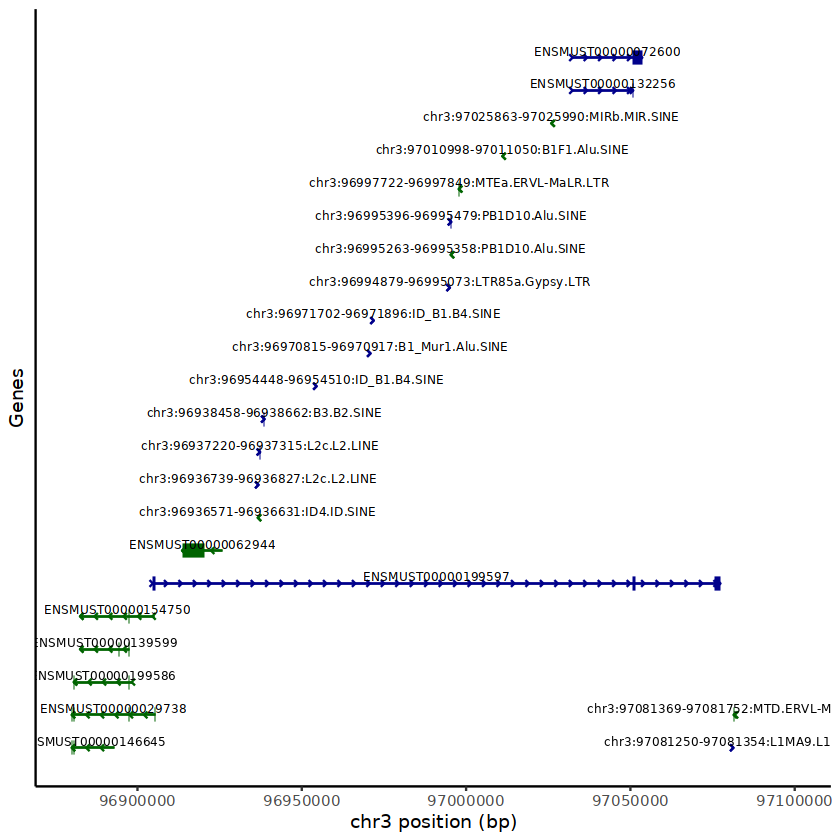

In [27]:
# plot gene and TE annotation Gja5
gene_plot <- AnnotationPlot(
  object = sample_te_gene,
  region = "chr3-96880000-97100000",
  mode = "transcript"
)
gene_plot

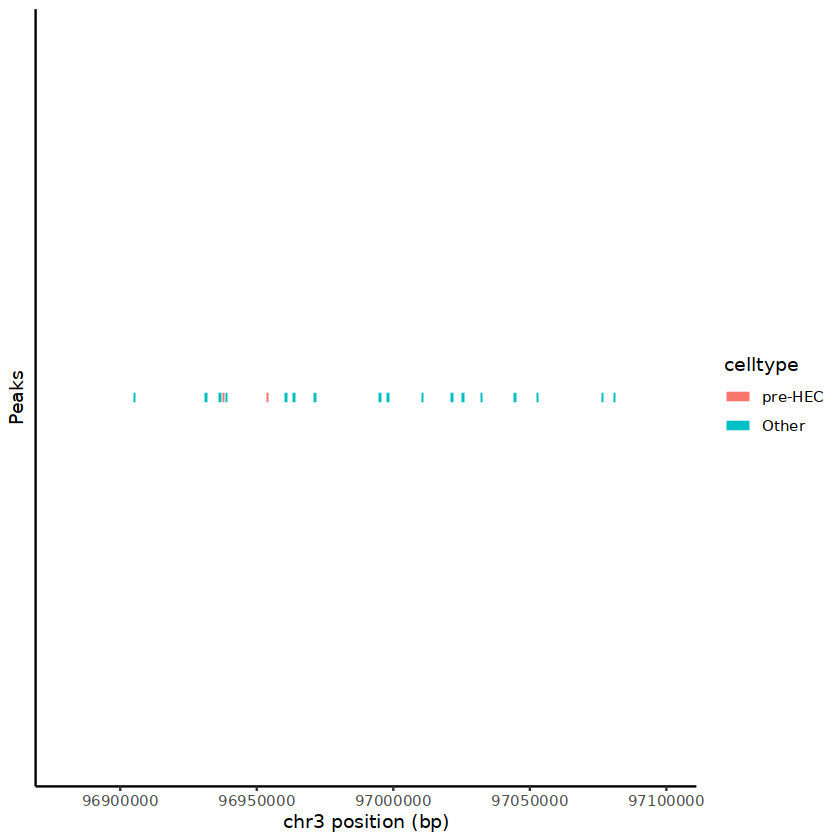

In [28]:
# plot peaks Gja5
peak_plot <- PeakPlot(sample_peak, region = "chr3-96880000-97100000", group.by = "celltype")
peak_plot

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


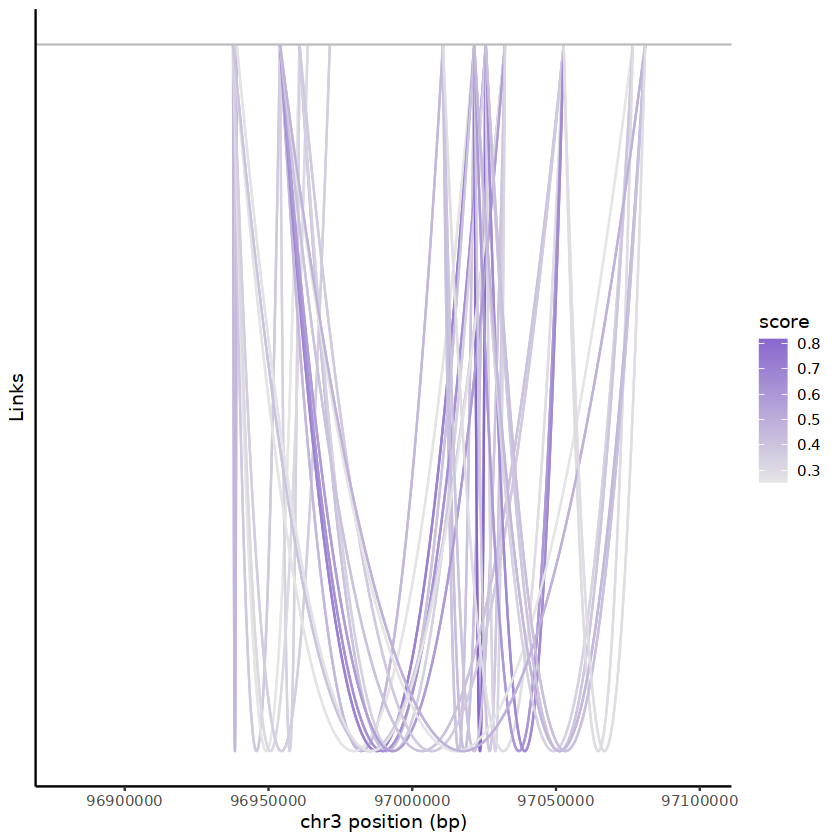

In [29]:
# plot links Gja5
link_plot <- LinkPlot(
  sample,
  region = "chr3-96880000-97100000",
  assay = "peaks",
  min.cutoff = 0.25,
  sep = c("-", "-"),
  extend.upstream = 0,
  extend.downstream = 0
) + scale_color_gradientn(colours = colorRampPalette(c("grey90","mediumpurple3"))(20))
link_plot

Warning message:
"Removed 8 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 8 rows containing missing values (`geom_segment()`)."


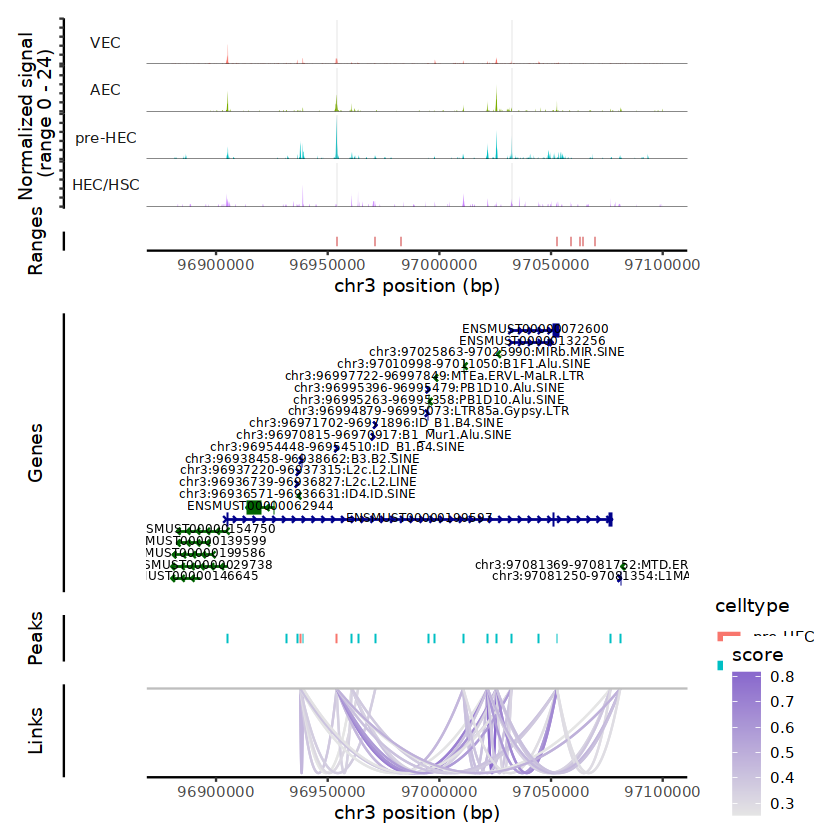

In [30]:
# combine all tracks plot Gja5
CombineTracks(plotlist = list(cov_plot, gene_plot, peak_plot, link_plot), heights = c(5, 6, 1, 2))
ggsave("./figure/coverage_plot_Gja5.pdf", width = 10, height = 8)

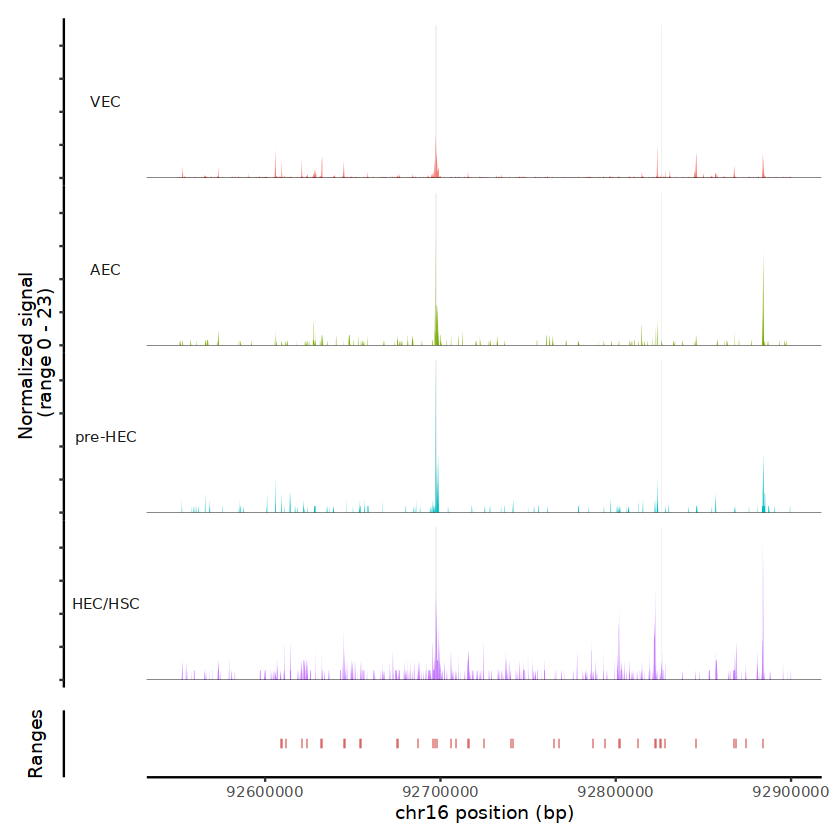

In [31]:
# plot coverage Runx1
els_runx1 <- StringToGRanges(c('chr16-92611029-92611326','chr16-92611696-92611859','chr16-92611859-92612062','chr16-92612559-92612903','chr16-92694771-92694997','chr16-92695477-92695784','chr16-92696696-92697039','chr16-92697585-92697794','chr16-92697936-92698221','chr16-92698227-92698428','chr16-92698654-92699000','chr16-92824410-92824579','chr16-92824880-92825207','chr16-92825217-92825421','chr16-92825576-92825812','chr16-92826714-92826883','chr16-92827944-92828292','chr16-92605727-92606072','chr16-92608247-92608417','chr16-92609034-92609305','chr16-92609318-92609518','chr16-92609553-92609903','chr16-92608672-92608857','chr16-92615345-92615689','chr16-92620803-92621080','chr16-92621082-92621268','chr16-92623871-92624220','chr16-92631625-92631959','chr16-92632113-92632442','chr16-92632474-92632624','chr16-92627366-92627676','chr16-92644670-92645011','chr16-92645240-92645555','chr16-92645696-92646037','chr16-92646260-92646534','chr16-92646752-92647079','chr16-92654659-92654952','chr16-92653951-92654262','chr16-92674155-92674497','chr16-92674924-92675262','chr16-92675765-92676035','chr16-92686960-92687306','chr16-92699306-92699506','chr16-92699517-92699737','chr16-92708815-92709159','chr16-92715520-92715867','chr16-92715919-92716087','chr16-92716102-92716355','chr16-92705652-92705914','chr16-92705930-92706280','chr16-92724534-92724850','chr16-92719790-92720046','chr16-92741346-92741688','chr16-92743793-92744122','chr16-92744288-92744613','chr16-92740123-92740324','chr16-92754052-92754272','chr16-92760221-92760397','chr16-92761057-92761315','chr16-92761362-92761665','chr16-92761986-92762281','chr16-92763725-92764034','chr16-92764765-92765111','chr16-92765510-92765713','chr16-92767386-92767733','chr16-92767882-92768197','chr16-92786616-92786815','chr16-92786876-92787050','chr16-92787052-92787394','chr16-92792912-92793236','chr16-92793829-92793984','chr16-92800838-92801167','chr16-92801610-92801945','chr16-92802363-92802678','chr16-92803127-92803437','chr16-92803654-92803859','chr16-92812485-92812832','chr16-92814447-92814699','chr16-92818487-92818815','chr16-92821860-92822110','chr16-92822119-92822466','chr16-92822564-92822840','chr16-92822848-92823138','chr16-92823335-92823486','chr16-92823619-92823968','chr16-92845232-92845477','chr16-92845684-92845967','chr16-92867281-92867631','chr16-92868560-92868905','chr16-92873740-92874033','chr16-92874054-92874386','chr16-92883900-92884236'))
ranges.highlight <- StringToGRanges(c("chr16-92697218-92697559","chr16-92825907-92826256"))
cov_plot <- CoveragePlot(
  object = sample,
  region = "chr16-92550000-92900000",
  region.highlight = ranges.highlight,
  ranges = els_runx1,
  annotation = FALSE,
  peaks = FALSE,
  links = FALSE
) + scale_fill_manual(values = alpha(c("#D82831", "#2077B2", "#9765BA", "#1BA138"), 0.33))
cov_plot
#ggsave("./figure/cov_plot_Gja5.pdf", width = 8, height = 3)

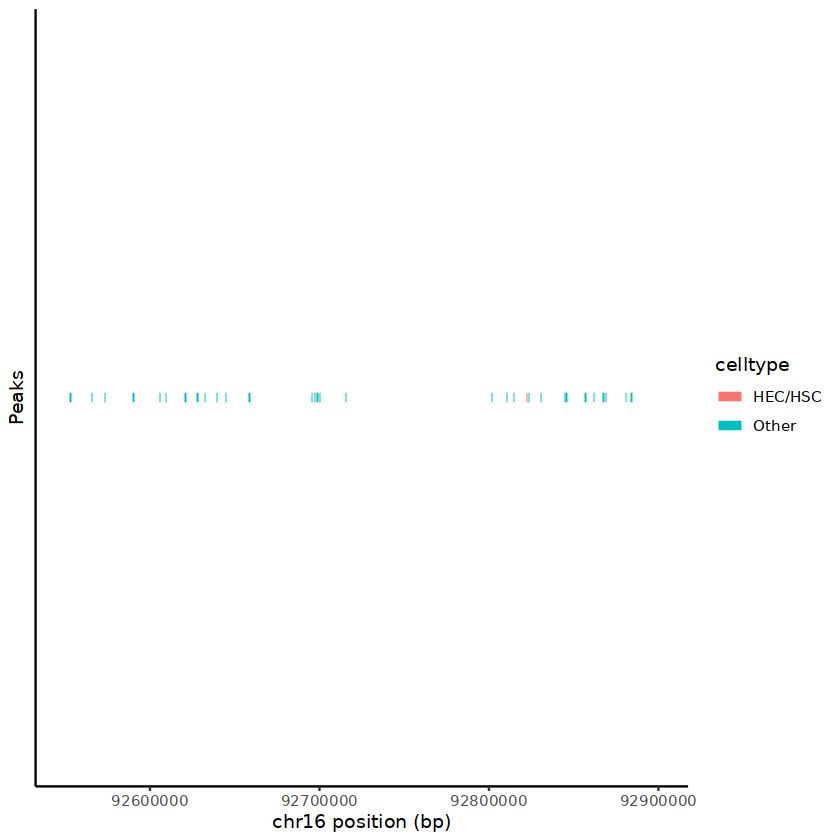

In [35]:
# plot peaks Runx1
peak_plot <- PeakPlot(sample_peak, region = "chr16-92550000-92900000", group.by = "celltype")
peak_plot

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


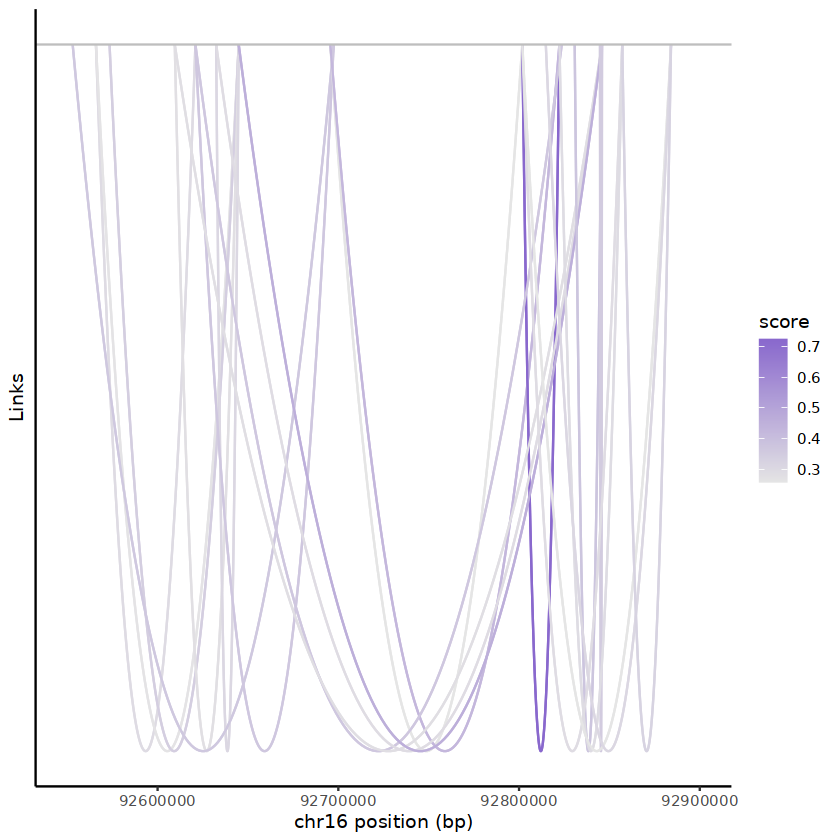

In [36]:
# plot links Runx1
link_plot <- LinkPlot(
  sample,
  region = "chr16-92550000-92900000",
  assay = "peaks",
  min.cutoff = 0.25,
  sep = c("-", "-"),
  extend.upstream = 0,
  extend.downstream = 0
) + scale_color_gradientn(colours = colorRampPalette(c("grey90","mediumpurple3"))(20))
link_plot

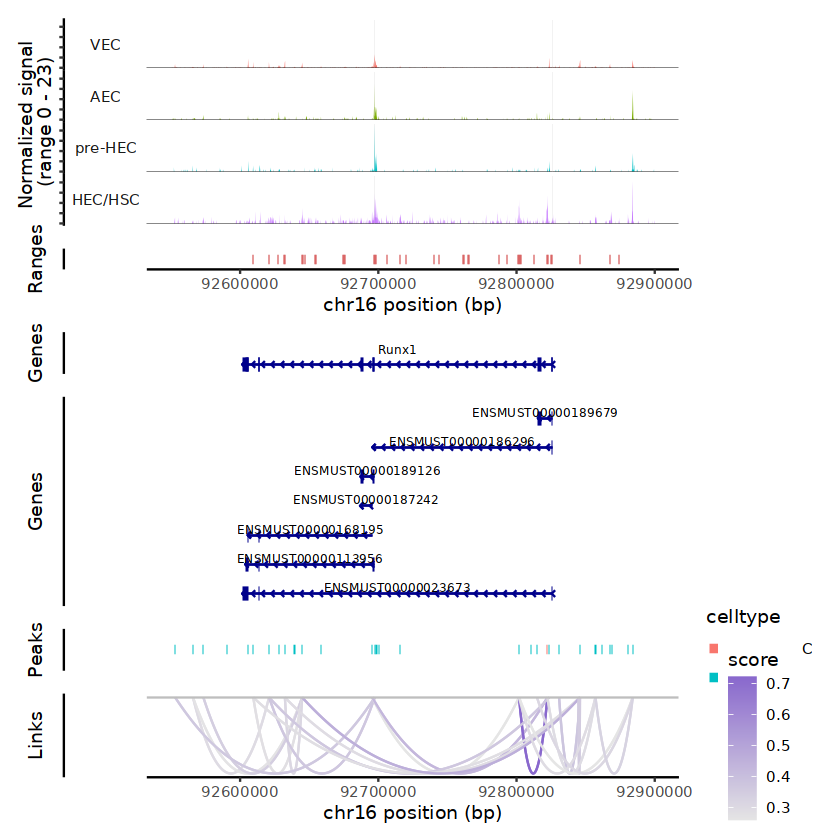

In [37]:
# combine all tracks plot Runx1
CombineTracks(plotlist = list(cov_plot, gene_plot, te_plot, peak_plot, link_plot), heights = c(6, 1, 5, 1, 2))
ggsave("./figure/coverage_plot_Runx1.pdf", width = 8, height = 9)

In [38]:
# get overlapped granges
gr1 <- da_peaks_all_significant_granges
gr2 <- StringToGRanges("chr16-92550000-92900000")
suppressWarnings({m <- findOverlaps(gr1, gr2, ignore.strand = TRUE)})
gr1.matched <- gr1[queryHits(m)]
mcols(gr1.matched) <- cbind.data.frame(mcols(gr1.matched), mcols(gr2[subjectHits(m)]))
gr1.matched

GRanges object with 1 range and 8 metadata columns:
       seqnames            ranges strand |       p_val avg_log2FC      pct1
          <Rle>         <IRanges>  <Rle> |   <numeric>  <numeric> <numeric>
  2449    chr16 92821961-92822703      * | 3.52383e-20    5.22147     0.357
            pct2   p_val_adj    celltype               peak_loc    category
       <numeric>   <numeric> <character>            <character> <character>
  2449      0.01 5.11143e-15     HEC/HSC chr16-92821961-92822..          TE
  -------
  seqinfo: 22 sequences from an unspecified genome; no seqlengths

In [39]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] cicero_1.3.9                       Gviz_1.42.1                       
 [3] monocle3_1.3.1                     SingleCellExperiment_1.20.1       
 [5] SummarizedExperiment_1.28.0        MatrixGenerics_1.10.0             
 [7] matrixStats_0.63.0                 Biobase_2.58.0                    
 [9] patchwork_1.1.2                    dplyr_1.1.1                       
[11] stringr_1.5.0